In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
url = 'D:\App Exes\VS Code\Proyecto Final Data\healthcare-dataset-stroke-data.csv'

Contexto de mi dataset:
Para este análisis, se han utilizado datos del dataset "Stroke Prediction Dataset" de Kaggle (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset). Este dataset contiene información sobre pacientes y si han sufrido un accidente cerebrovascular (ACV) o no. Los datos fueron recolectados en hospitales de la India y constan de 12 variables, que incluyen información demográfica, de estilo de vida y de salud del paciente. El objetivo es utilizar estas variables para predecir si un paciente es propenso a sufrir un ACV.

El dataset contiene 5109 observaciones con 12 variables. Las variables son las siguientes:

id: el numero unico de paciente
gender: genero del paciente (femenino = 0, masculino = 1, otro = 2)
age: edad del paciente
hypertension: si el paciente tiene o no hipertension (1 = si, 0 = no)
heart_disease: si el paciente tiene o no DVC o enfermedad cardiovascular (1 = si, 0 = no)
ever_married: si el paciente estuvo o no casado
Residence_type: tipo de residencia del paciente (urbano = 1 o rural = 0)
avr_glucose_level: nivel de glucosa en sangre del paciente
bmi: masa corporal del paciente
stroke: si el paciente sufrio o no ACV (1 = si, 0 = no)
work_type_Govt_job: Si el paciente trabaja para el gobierno (1 = si, 0 = no)
work_type_Never_worked: Si el paciente nunca trabajo (1 = si, 0 = no)
work_type_Private: Si el paciente trabaja como privado (1 = si, 0 = no)
work_type_Self-employed: Si el paciente es empleador (1 = si, 0 = no)
work_type_children: Si es un niño (1 = si, 0 = no)
smoking_status_Unknown: Si se desconoce si el paciente fuma (1 = si, 0 = no)
smoking_status_formerly smoked: Si el paciente fumaba (1 = si, 0 = no)
smoking_status_never smoked: Si el paciente nunca fumo (1 = si, 0 = no)
smoking_status_smoke: Si el paciente fuma (1 = si, 0 = no)

Importo y proceso los datos
Tambien modifico y guardo el Dataset en un .CSV distinto

In [2]:
df = pd.read_csv(url, sep = ',')
df = pd.get_dummies(df, columns=['work_type'], prefix='work_type')
df = pd.get_dummies(df, columns=['smoking_status'], prefix='smoking_status')

#Reemplaza valores nulos de BMI promediando por rango edades cercanas
promedio_bmi_edades = df.groupby('age')['bmi'].mean()
df['bmi'] = df.apply(lambda row: promedio_bmi_edades[row['age']] if pd.isnull(row['bmi']) else row['bmi'], axis=1)

#Reemplazo valores strings por valores numericos
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0, 'Other': 2})
df['ever_married'] = df['ever_married'].replace({'No': 0, 'Yes': 1})
df['Residence_type'] = df['Residence_type'].replace({'Rural': 0, 'Urban': 1})

df_stroke = df.loc[df['stroke'] == 1]
df_nostroke = df.loc[df['stroke'] == 0]
df = df.astype(int)

# Creo una columna con valores 1 si las posibilidades de acv son altas o 0 si las posibilidades son bajas
def posibilidad_stroke(row):
    if row['hypertension'] == 1 or row['heart_disease'] == 1 or row['stroke'] == 1:
        return 1
    else:
        return 0

# Aplicar la función a cada fila del DataFrame
df['posibilidad_stroke'] = df.apply(posibilidad_stroke, axis=1)
df.to_csv('Dataframe.csv', index=False)

Verifico Duplicados

In [3]:
df.duplicated().sum()

0

Info del Dataframe y las variables

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   id                              5110 non-null   int32
 1   gender                          5110 non-null   int32
 2   age                             5110 non-null   int32
 3   hypertension                    5110 non-null   int32
 4   heart_disease                   5110 non-null   int32
 5   ever_married                    5110 non-null   int32
 6   Residence_type                  5110 non-null   int32
 7   avg_glucose_level               5110 non-null   int32
 8   bmi                             5110 non-null   int32
 9   stroke                          5110 non-null   int32
 10  work_type_Govt_job              5110 non-null   int32
 11  work_type_Never_worked          5110 non-null   int32
 12  work_type_Private               5110 non-null   int32
 13  wor

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,posibilidad_stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,0.414286,43.215264,0.097456,0.054012,0.656164,0.508023,105.658317,28.470646,0.048728,0.128571,0.004305,0.572407,0.160274,0.134442,0.302153,0.173190,0.370254,0.154403,0.168102
std,21161.721625,0.493044,22.633866,0.296607,0.226063,0.475034,0.499985,45.275290,7.719681,0.215320,0.334758,0.065480,0.494778,0.366896,0.341160,0.459236,0.378448,0.482920,0.361370,0.373993
min,67.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17741.250000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,36932.000000,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.000000,28.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,54682.000000,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.000000,32.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.000000,97.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Analisis exploratorio de datos

In [5]:
df.describe().T[["mean", "std", "min", "max"]]

,mean,std,min,max
id,36517.829354,21161.721625,67.0,72940.0
gender,0.414286,0.493044,0.0,2.0
age,43.215264,22.633866,0.0,82.0
hypertension,0.097456,0.296607,0.0,1.0
heart_disease,0.054012,0.226063,0.0,1.0
ever_married,0.656164,0.475034,0.0,1.0
Residence_type,0.508023,0.499985,0.0,1.0
avg_glucose_level,105.658317,45.275290,55.0,271.0
bmi,28.470646,7.719681,10.0,97.0
stroke,0.048728,0.215320,0.0,1.0


In [7]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,posibilidad_stroke
0,9046,1,67,0,1,1,1,228,36,1,0,0,1,0,0,0,1,0,0,1
1,51676,0,61,0,0,1,0,202,30,1,0,0,0,1,0,0,0,1,0,1
2,31112,1,80,0,1,1,0,105,32,1,0,0,1,0,0,0,0,1,0,1
3,60182,0,49,0,0,1,1,171,34,1,0,0,1,0,0,0,0,0,1,1
4,1665,0,79,1,0,1,0,174,24,1,0,0,0,1,0,0,0,1,0,1


Introducción:
Los accidentes cerebrovasculares (ACV) son eventos médicos graves que pueden tener consecuencias devastadoras en la vida de las personas. La detección temprana de los factores de riesgo es fundamental para prevenir estos eventos. En este análisis, utilizaremos el dataset "Stroke Prediction Dataset" para explorar las variables relacionadas con pacientes y su propensión a sufrir un ACV. Nuestro objetivo es identificar patrones y desarrollar un modelo predictivo para ayudar en la prevención de accidentes cerebrovasculares.

¿A quien afecta mas los ACV? ¿Existe algun riesgo segun el genero? ¿La edad es un factor importante?

El dataset contiene información diversa sobre los pacientes. Comenzaremos analizando las características demográficas y de estilo de vida. Observamos que hay una distribución equilibrada de género en el dataset, con aproximadamente la mitad de los pacientes siendo hombres y la otra mitad mujeres. Además, hay una pequeña proporción de pacientes(solo uno) con un género "otro".

Al investigar más a fondo, encontramos que la edad de los pacientes varía ampliamente, desde jóvenes hasta ancianos. Esto nos lleva a explorar la relación entre la edad y los accidentes cerebrovasculares. Encontramos que existe una tendencia general de que el riesgo de ACV aumenta con la edad, lo cual es consistente con la literatura médica.

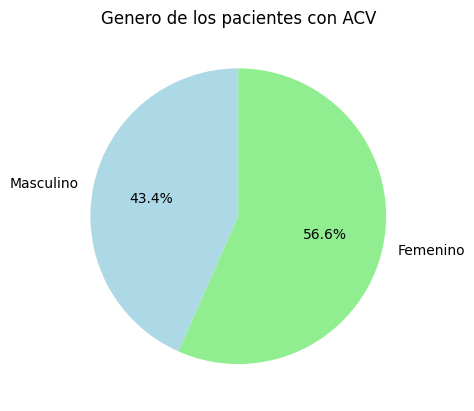

In [8]:
# Cuenta los valores únicos en la columna "ever_married" del DataFrame df_stroke
married_counts = df_stroke['gender'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Masculino', 'Femenino']
values = [married_counts[1], married_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightblue', 'lightgreen']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Genero de los pacientes con ACV')

plt.show()

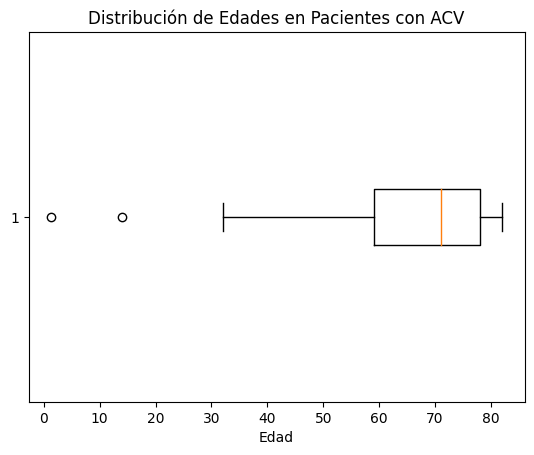

In [9]:
plt.boxplot(df_stroke['age'], vert=False)
plt.xlabel('Edad')
plt.title('Distribución de Edades en Pacientes con ACV')
plt.show()

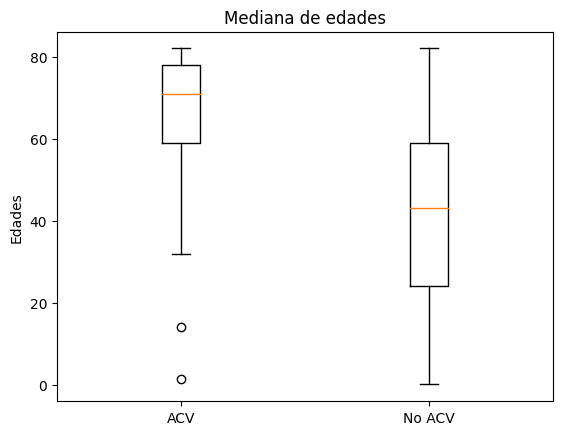

In [10]:
# Crea una lista con los datos de BMI y avr_glucose_level
acv = df_stroke['age']
no_acv = df_nostroke['age']
# Crea una lista con los nombres de las variables
labels = ['ACV', 'No ACV']

# Crea un boxplot con los datos
plt.boxplot([acv, no_acv], labels=labels)
plt.ylabel('Edades')
plt.title('Mediana de edades')

plt.show()

¿Las enfermedades del corazon afecta a los ACV?

Además de la edad, también examinamos otras variables de salud. Observamos que algunos pacientes tienen hipertensión, mientras que otros padecen enfermedades cardiovasculares. Estos factores de riesgo están bien establecidos en la literatura médica y se sabe que contribuyen al desarrollo de accidentes cerebrovasculares. Hay que destacar que de los 5000 pacientes solo 249 sufrieron ACV, este dato aunque pareciera que no son relevantes, de los 249 casos al menos el 60% tienen una de estas caracteristicas.

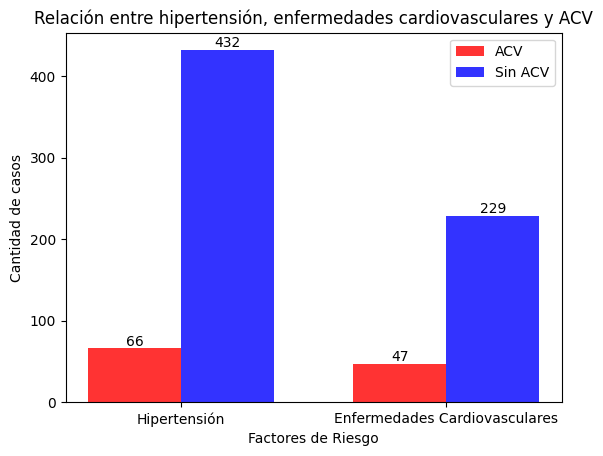

In [11]:
stroke_data = df[df['stroke'] == 1]
no_stroke_data = df[df['stroke'] == 0]

hypertension_stroke = stroke_data[stroke_data['hypertension'] == 1].shape[0]
hypertension_no_stroke = no_stroke_data[no_stroke_data['hypertension'] == 1].shape[0]

heart_disease_stroke = stroke_data[stroke_data['heart_disease'] == 1].shape[0]
heart_disease_no_stroke = no_stroke_data[no_stroke_data['heart_disease'] == 1].shape[0]

# Preparar los datos para el gráfico
stroke_data = [hypertension_stroke, heart_disease_stroke]
no_stroke_data = [hypertension_no_stroke, heart_disease_no_stroke]
x = np.arange(len(stroke_data))

# Ancho de las barras
bar_width = 0.35

# Etiquetas para las barras
labels = ['Hipertensión', 'Enfermedades Cardiovasculares']

# Colores para las barras
colors_stroke = ['red', 'red']
colors_no_stroke = ['blue', 'blue']

# Crear el gráfico de barras
plt.bar(x, stroke_data, width=bar_width, align='center', label='ACV', color=colors_stroke, alpha=0.8)
plt.bar(x + bar_width, no_stroke_data, width=bar_width, align='center', label='Sin ACV', color=colors_no_stroke, alpha=0.8)

# Añadir el valor numérico en cada barra
for i, v in enumerate(stroke_data):
    plt.text(i, v, str(v), color='black', ha='center', va='bottom')
for i, v in enumerate(no_stroke_data):
    plt.text(i + bar_width, v, str(v), color='black', ha='center', va='bottom')

# Configurar las etiquetas de los ejes y el título
plt.xlabel('Factores de Riesgo')
plt.ylabel('Cantidad de casos')
plt.title('Relación entre hipertensión, enfermedades cardiovasculares y ACV')
plt.xticks(x + bar_width/2, labels)
plt.legend()

# Mostrar el gráfico
plt.show()

¿Son las relaciones peligrosas para la salud?

El estado marital y el tipo de residencia también pueden ser factores relevantes en la predicción de los ACV. Al explorar estos datos, encontramos que hay una gran cantidad de pacientes casados que sufrieron ACV. Esto me lleva a pensar que una de las causas sea el estres.

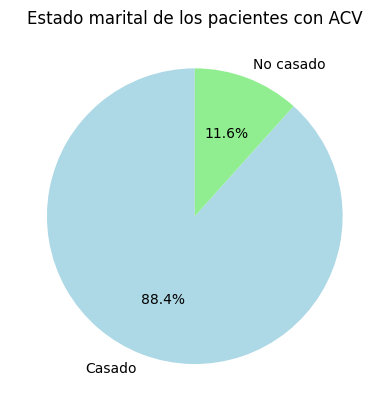

In [12]:
# Cuenta los valores únicos en la columna "ever_married" del DataFrame df_stroke
married_counts = df_stroke['ever_married'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Casado', 'No casado']
values = [married_counts[1], married_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightblue', 'lightgreen']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Estado marital de los pacientes con ACV')

plt.show()

¿Es relevante el tipo de residencia?
La ubicación geográfica de los pacientes, ya sea en áreas urbanas o rurales, podría no influir en su salud en general

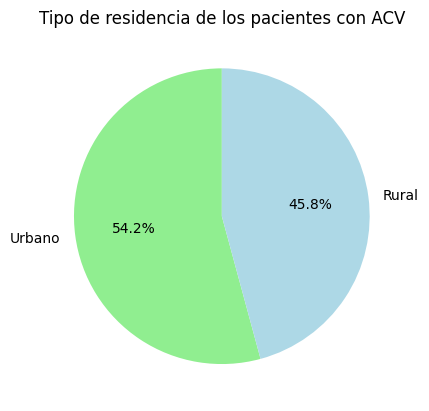

In [13]:
# Cuenta los valores únicos en la columna "Residence_type" del DataFrame df_stroke
residence_counts = df_stroke['Residence_type'].value_counts()

# Etiquetas y valores para el gráfico de torta
labels = ['Urbano', 'Rural']
values = [residence_counts[1], residence_counts[0]]

# Colores para cada sector del gráfico de torta
colors = ['lightgreen', 'lightblue']

# Crea el gráfico de torta
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Tipo de residencia de los pacientes con ACV')

plt.show()

¿Que tanto afecta el estres del trabajo a la salud?

El numero de empleados que sufrieron ACV es significativamente mayor al de empleador, esto podria ser un reflejo del estres que generan los trabajos y sobre todo los jefes hacia los empleados

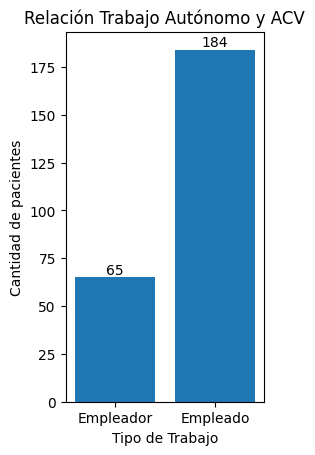

In [14]:
stroke_work = df_stroke['work_type_Self-employed'].value_counts()

labels_work = ['Empleador', 'Empleado']
values_work = [stroke_work[1], stroke_work[0]]

plt.subplot(1, 2, 2)
plt.bar(labels_work, values_work)
plt.xlabel('Tipo de Trabajo')
plt.ylabel('Cantidad de pacientes')
plt.title('Relación Trabajo Autónomo y ACV')
plt.subplots_adjust(wspace=0.5)


for i, v in enumerate(values_work):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

¿Son los fumadores el grupo de riesgo?

En el análisis de variables relacionadas con el estilo de vida, encontramos correlaciones significativas entre el tabaquismo, el trabajo autónomo y el riesgo de ACV. El tabaquismo, un factor de riesgo bien conocido para diversos problemas de salud, también está asociado con un mayor riesgo de accidentes cerebrovasculares. Los pacientes que fumaban y fuman presentaban una mayor incidencia de ACV en comparación con los no fumadores.

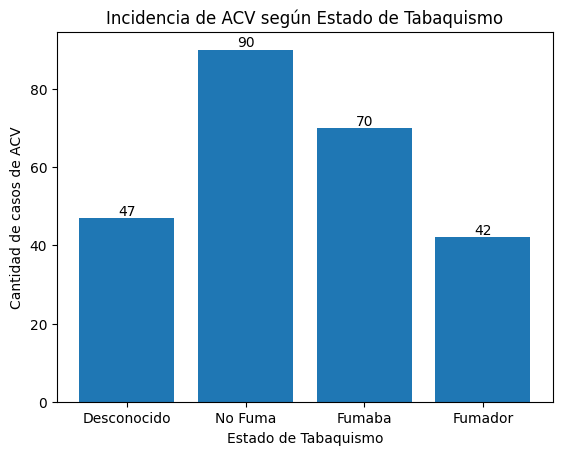

In [15]:
stroke_smoking = df_stroke[['smoking_status_Unknown', 'smoking_status_formerly smoked', 'smoking_status_never smoked', 'smoking_status_smokes']].sum()

labels_smoking = ['Desconocido', 'No Fuma', 'Fumaba', 'Fumador']
values_smoking = [stroke_smoking['smoking_status_Unknown'], stroke_smoking['smoking_status_never smoked'], stroke_smoking['smoking_status_formerly smoked'], stroke_smoking['smoking_status_smokes']]

plt.bar(labels_smoking, values_smoking)

for i, v in enumerate(values_smoking):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Estado de Tabaquismo')
plt.ylabel('Cantidad de casos de ACV')
plt.title('Incidencia de ACV según Estado de Tabaquismo')

plt.show()

Ahora tambien hay que tener en cuenta que la mayoria de los fumadores lo hacen por el estres y muy pocos por socializar y estar en malas condiciones de trabajo o condiciones que generen estres podria llevarte a fumar y aumentar los riesgos de ACV.

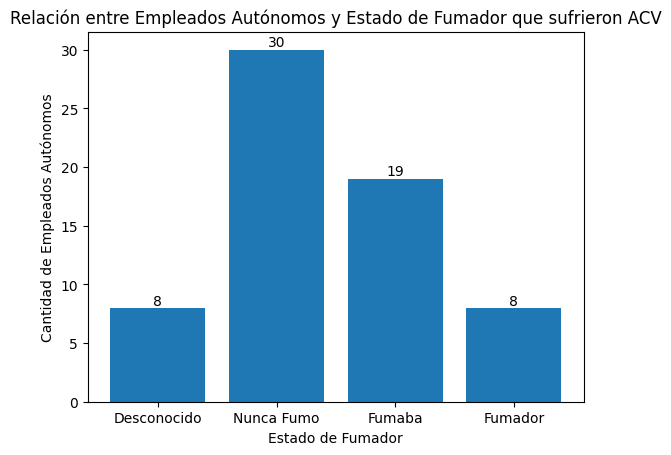

In [16]:
self_employed = df_stroke[df_stroke['work_type_Self-employed'] == 1]

smoking_counts = self_employed[['smoking_status_Unknown', 'smoking_status_never smoked', 'smoking_status_formerly smoked', 'smoking_status_smokes']].sum()

labels = ['Desconocido', 'Nunca Fumo', 'Fumaba', 'Fumador']

values = [smoking_counts['smoking_status_Unknown'], smoking_counts['smoking_status_never smoked'], smoking_counts['smoking_status_formerly smoked'], smoking_counts['smoking_status_smokes']]

plt.bar(labels, values)

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.xlabel('Estado de Fumador')
plt.ylabel('Cantidad de Empleados Autónomos')
plt.title('Relación entre Empleados Autónomos y Estado de Fumador que sufrieron ACV')

plt.show()

¿Son los estudios de BMI y Glucosa en sangre factores para predecir el ACV? ¿Afecta el tabaquismo a estos mismos?

Por ultimo investigamos los datos sobre la salud en cuestion de peso relacionado con la altura(BMI) y azucar en sangre(Niveles de glucosa) se cree que los niveles altos de glucosa se relacionan con los fumadores. Se puede notar que el BMI en ambos casos(ACV y No ACV) es similar, pero los niveles de glucosa en los casos de ACV son mayores, segun investigaciones medicas esto puede ser generado por ser fumador.

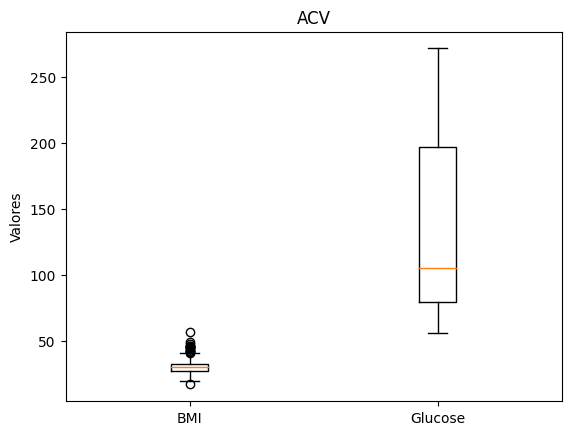

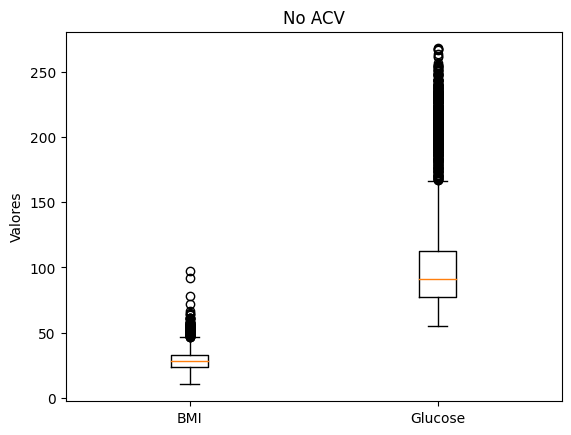

In [17]:
bmi_data = df_stroke['bmi']
glucose_data = df_stroke['avg_glucose_level']

# Crea una lista con los nombres de las variables
labels = ['BMI', 'Glucose']

# Crea un boxplot con los datos
plt.boxplot([bmi_data, glucose_data], labels=labels)
plt.ylabel('Valores')
plt.title('ACV')

plt.show()

bmi_data = df_nostroke['bmi']
glucose_data = df_nostroke['avg_glucose_level']

# Crea una lista con los nombres de las variables
labels = ['BMI', 'Glucose']

# Crea un boxplot con los datos
plt.boxplot([bmi_data, glucose_data], labels=labels)
plt.ylabel('Valores')
plt.title('No ACV')

plt.show()

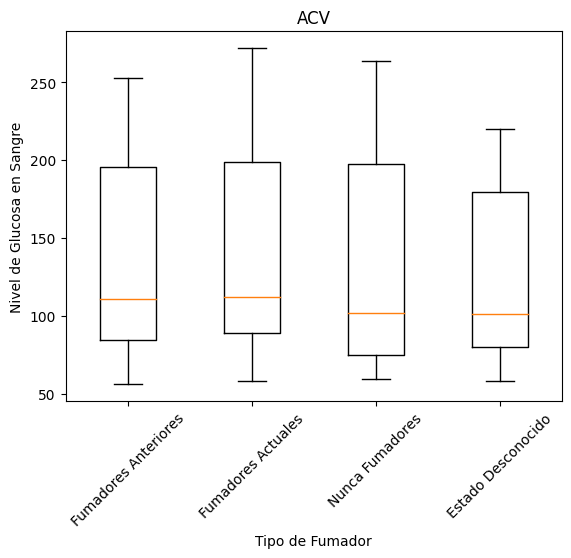

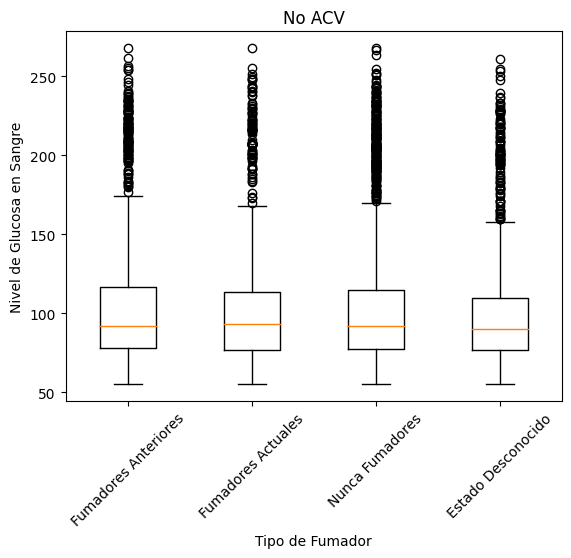

In [18]:
# Filtrar el DataFrame por cada tipo de fumador
former_smokers = df_stroke[df_stroke['smoking_status_formerly smoked'] == 1]
current_smokers = df_stroke[df_stroke['smoking_status_smokes'] == 1]
never_smokers = df_stroke[df_stroke['smoking_status_never smoked'] == 1]
unknown_smokers = df_stroke[df_stroke['smoking_status_Unknown'] == 1]

# Crear una lista con los datos de glucosa para cada tipo de fumador
data = [former_smokers['avg_glucose_level'],
        current_smokers['avg_glucose_level'],
        never_smokers['avg_glucose_level'],
        unknown_smokers['avg_glucose_level']]

# Etiquetas para el gráfico
labels = ['Fumadores Anteriores', 'Fumadores Actuales', 'Nunca Fumadores', 'Estado Desconocido']

# Crear el gráfico de caja
plt.boxplot(data, labels=labels)
plt.xlabel('Tipo de Fumador')
plt.ylabel('Nivel de Glucosa en Sangre')
plt.title('ACV')
plt.xticks(rotation=45)

plt.show()

# Filtrar el DataFrame por cada tipo de fumador
former_smokers = df_nostroke[df_nostroke['smoking_status_formerly smoked'] == 1]
current_smokers = df_nostroke[df_nostroke['smoking_status_smokes'] == 1]
never_smokers = df_nostroke[df_nostroke['smoking_status_never smoked'] == 1]
unknown_smokers = df_nostroke[df_nostroke['smoking_status_Unknown'] == 1]

# Crear una lista con los datos de glucosa para cada tipo de fumador
data = [former_smokers['avg_glucose_level'],
        current_smokers['avg_glucose_level'],
        never_smokers['avg_glucose_level'],
        unknown_smokers['avg_glucose_level']]

# Etiquetas para el gráfico
labels = ['Fumadores Anteriores', 'Fumadores Actuales', 'Nunca Fumadores', 'Estado Desconocido']

# Crear el gráfico de caja
plt.boxplot(data, labels=labels)
plt.xlabel('Tipo de Fumador')
plt.ylabel('Nivel de Glucosa en Sangre')
plt.title('No ACV')
plt.xticks(rotation=45)

plt.show()

Riesgo de ACV: En el dataset, se encontró que solo una minoría de los pacientes ha experimentado un accidente cerebrovascular (ACV). Esto resalta la importancia de los esfuerzos de prevención y la necesidad de identificar los factores de riesgo asociados.

Variables demográficas: Se encontro que en los pacientes que tuvieron un ACV estaban en su mayoria casados. La ubicación geográfica de los pacientes (áreas urbanas o rurales) no solto informacion util.

Estilo de vida: A través del análisis de variables relacionadas con el estilo de vida, se encontraron correlaciones significativas entre el tabaquismo, el trabajo autónomo y el riesgo de ACV.

Factores de salud: No se observó una correlación entre niveles altos de índice de masa corporal (BMI) y los ACV, pero si que la mediana del nivel de glucosa es un poco mayor. Creo que los niveles altos de azucar pueden estar relacionados de alguna forma.

En resumen:

La teoria principal es que existe una fuerte correlacion entre variables como estar casado, ser empleado, hipertension, enfermedades del corazon, fumar y los niveles altos de glucosa. Todas estas variables se ralacionan entre si con el estres, lamentablemente no hay una forma de medir el estres y si existe no estan los datos para estudiarlos en el dataset pero el estres podria ser la principal causa de los ACV.